# Pneumonia X-Ray Image Classification: Modeling

Authors:
- Arthur Kim
    - Github: arthurk2323
- Mia Fryer
    - Github: miazfryer
- Ian Sharff
    - Github: iansharff
___

## Data Preparation and Loading

In [2]:
import os
import sys
import pickle
import PIL
from PIL import Image
import io
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,\
array_to_img,\
img_to_array,\
load_img

from tensorflow.keras.models import load_model

import tools.visualizations as vis
import tools.misc as misc

In [3]:
# Path Constants
TRAIN_PATH = 'data/split/train'
VAL_PATH = 'data/split/val'
TEST_PATH = 'data/split/test'

# Image Processing Constants
BATCH_SIZE = 32
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Change for test runs
EPOCHS = 30

In [4]:
# Call function to display counts and return dict of subtotals
counts = misc.count_files([TRAIN_PATH, VAL_PATH, TEST_PATH])


TRAIN
-------------------------
	PNEUMONIA: 2564
	NORMAL: 950

	SUBTOTAL: 3514
VAL
-------------------------
	PNEUMONIA: 855
	NORMAL: 317

	SUBTOTAL: 1172
TEST
-------------------------
	PNEUMONIA: 854
	NORMAL: 316

	SUBTOTAL: 1170
-------------------------
TOTAL: 5856 files


In [5]:
counts

{'train': 3514, 'val': 1172, 'test': 1170}

In [53]:
class_weight = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels,
)

array([1.84947368, 0.68525741])

In [6]:
# DirectoryIterator parameters for flow_from_directory
gen_params = {
    'target_size': (64, 64),
    'color_mode': 'grayscale',
    'class_mode': 'binary',
}

In [69]:
## CALLBACKS

Here, the images are accessed through `ImageDataGenerator`s and rescaled. The batch sizees are set to the file count for a given subset (training, validation, and testing) within the `flow_from_directory` method call, so all images are saved to memory as 64x64 grayscale images (shape = (n_images, 64, 64, 1)) upon calling `next` on the `DirectoryIterators` produced. 

In [7]:
# Load 
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_PATH, 
    batch_size=counts['train'],
    **gen_params
)

# Get all the data in the directory data/val (855+317 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_PATH, 
    batch_size=counts['val'],
    **gen_params
)

# Get all the data in the directory data/test (854+316 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_PATH,
    batch_size=counts['test'],
    **gen_params
)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [8]:
# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [9]:
# Display the shape of the image and label arrays (this cell may take a while to load)
print('TRAIN\n' + '-'*50)
print(f'\ttrain_images shape: {train_images.shape}')
print(f'\ttrain_labels shape: {train_labels.shape}')
print('\nVALIDATION\n' + '-'*50)
print(f'\tval_images shape: {val_images.shape}')
print(f'\tval_labels shape: {val_labels.shape}')
print('\nTEST\n' + '-'*50)
print(f'\ttest_images shape: {test_images.shape}')
print(f'\ttest_labels shape: {test_labels.shape}')
    

TRAIN
--------------------------------------------------
	train_images shape: (3514, 64, 64, 1)
	train_labels shape: (3514,)

VALIDATION
--------------------------------------------------
	val_images shape: (1172, 64, 64, 1)
	val_labels shape: (1172,)

TEST
--------------------------------------------------
	test_images shape: (1170, 64, 64, 1)
	test_labels shape: (1170,)


In [10]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     TRAIN_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     VAL_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     TEST_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

In [11]:
class_names = {v: k for k, v in train_generator.class_indices.items()}
print(class_names)

{0: 'NORMAL', 1: 'PNEUMONIA'}


SyntaxError: unexpected EOF while parsing (<ipython-input-12-81a33d937fa8>, line 1)

In [ ]:
# ## GET SAMPLE IMAGES
# for dirpath, dirnames, filenames in os.walk():
#     for dirname in dirnames:
#         if dirname == 'BACTERIA':
#             bacteria = load_img(os.path.join(dirname))
vir_samples = [
    'data/VIRUS/person1_virus_11.jpeg',
    'data/VIRUS/person1_virus_12.jpeg',
    'data/VIRUS/person1_virus_13.jpeg',
]

bac_samples = [
    'data/BACTERIA/person1_bacteria_1.jpeg',
    'data/BACTERIA/person1_bacteria_2.jpeg',
    'data/BACTERIA/person10_bacteria_43.jpeg'
]

norm_samples = [
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg'
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for 
        

# ## PLOT SAMPLE IMAGES
# with plt.style.context('images/presentation.mplstyle'):
#     fig, axes = plt.subplots(2, 3, figsize=(10, 8))
#     for i, ax in enumerate(axes.flatten()):
#         if i < 3:
#             ax.imshow(norm_samples[i], cmap=plt.cm.binary)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.set_title('NORMAL')
#         else:
#             ax.imshow(pneu_samples[i-4], cmap=plt.cm.binary)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.set_title('PNEUMONIA', color='darkred')
#     fig.tight_layout()
#     plt.axis('off')
#     plt.show()

In [78]:
vir_samples = [
    'data/VIRUS/person1_virus_11.jpeg',
    'data/VIRUS/person1_virus_12.jpeg',
    'data/VIRUS/person1_virus_13.jpeg',
]

bac_samples = [
    'data/BACTERIA/person1_bacteria_1.jpeg',
    'data/BACTERIA/person1_bacteria_2.jpeg',
    'data/BACTERIA/person10_bacteria_43.jpeg'
]

norm_samples = [
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg'
]

In [ ]:
plt.style.use('images/')

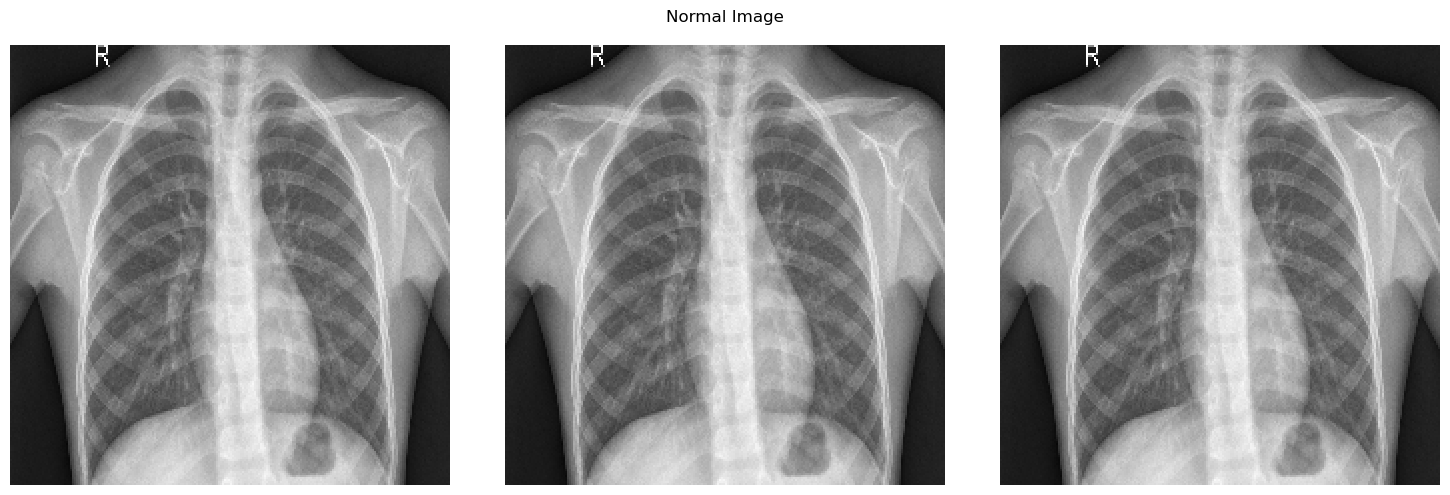

In [93]:
import glob
import cv2
normal = glob.glob(TRAIN_PATH+"NORMAL/*.jpeg")
pneumonia = glob.glob(TRAIN_PATH+"PNEUMONIA/*.jpeg")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(norm_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Normal Image")
fig.tight_layout()       
plt.show()

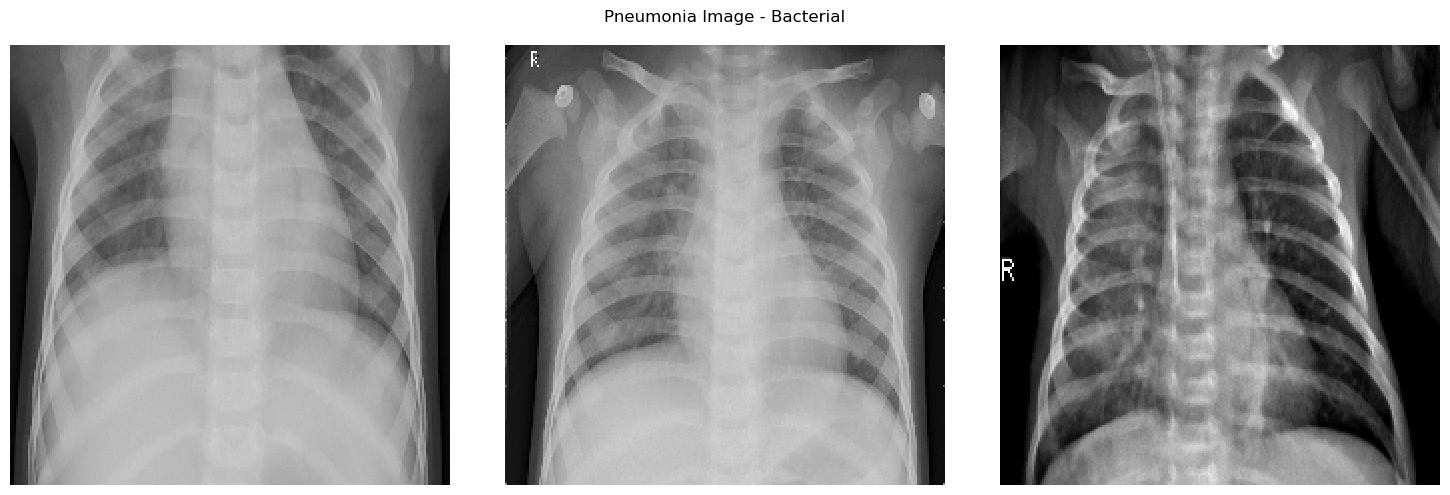

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(bac_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Image - Bacterial")
fig.tight_layout()
plt.show()

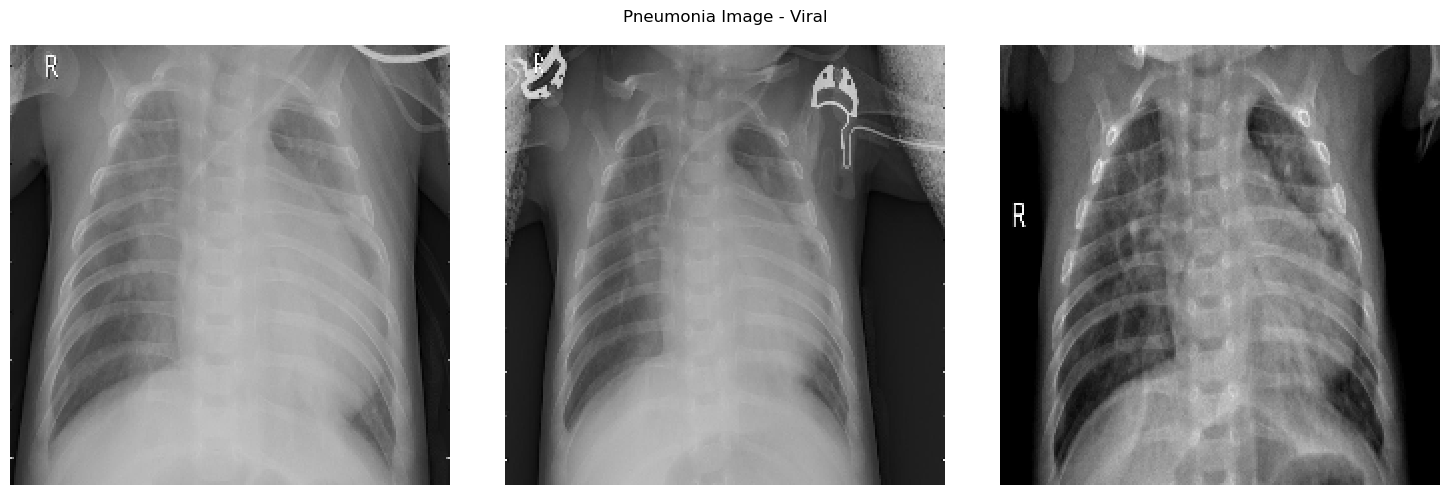

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(vir_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Image - Viral")
fig.tight_layout()   
plt.show()

## Model Building and Evaluation

### Dummy Model

In [13]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

In [14]:
dummy_clf.score(train_images, train_labels)

0.7296528173022196

In [15]:
dummy_clf.score(val_images,val_labels)

0.7295221843003413

In [16]:
dummy_clf.score(test_images,test_labels)

0.7299145299145299

### Model 1: Baseline Neural Network

In [17]:
np.random.seed(123)
model1 = models.Sequential()
model1.add(layers.Flatten(input_shape=(64, 64, 1)))
model1.add(layers.Dense(2, activation='relu'))

In [18]:
model1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history1 = model1.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 1s 3ms/step - loss: 8.3914 - acc: 0.2890 - val_loss: 7.6887 - val_acc: 0.2705
Epoch 2/30
110/110 [==============================] - 0s 3ms/step - loss: 7.6879 - acc: 0.2800 - val_loss: 7.6887 - val_acc: 0.2705
Epoch 3/30
110/110 [==============================] - 0s 2ms/step - loss: 7.6891 - acc: 0.2663 - val_loss: 7.6887 - val_acc: 0.2705
Epoch 4/30
110/110 [==============================] - 0s 2ms/step - loss: 7.6879 - acc: 0.2795 - val_loss: 7.6887 - val_acc: 0.2705
Epoch 5/30
110/110 [==============================] - 0s 2ms/step - loss: 7.6882 - acc: 0.2764 - val_loss: 7.6887 - val_acc: 0.2705
Epoch 6/30
110/110 [==============================] - 0s 2ms/step - loss: 7.6882 - acc: 0.2763 - val_loss: 7.6887 - val_acc: 0.2705
Epoch 7/30
110/110 [==============================] - 0s 2ms/step - loss: 7.6888 - acc: 0.2697 - val_loss: 7.6887 - val_acc: 0.2705
Epoch 8/30
110/110 [==============================] - 0s 2ms/step - loss: 7.

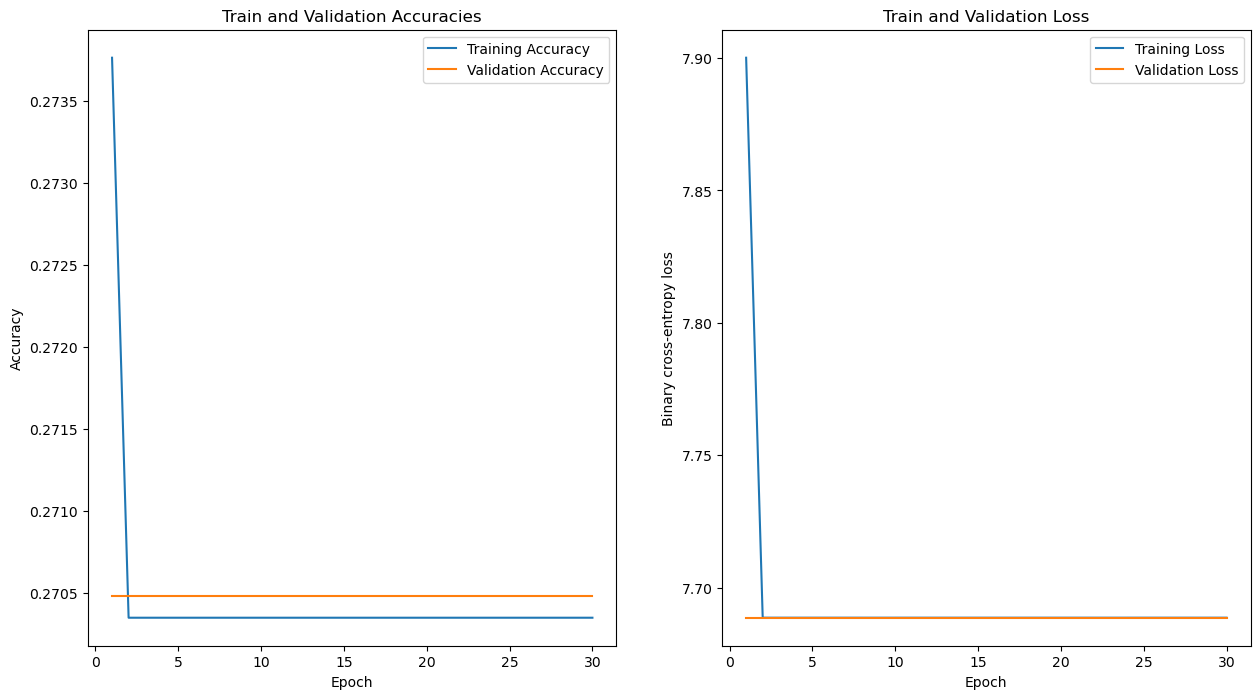

In [19]:
vis.plot_loss_accuracy(history1)

In [20]:
results_train = model1.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 459us/step - loss: 7.6887 - acc: 0.2703


In [21]:
results_test = model1.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 533us/step - loss: 7.6887 - acc: 0.2701


In [22]:
results_train

[7.688717842102051, 0.2703471779823303]

In [23]:
results_test

[7.688745498657227, 0.27008548378944397]

### Model 2: Neural Network with Dense Layers

In [24]:
np.random.seed(123)
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(64, 64, 1)))
model2.add(layers.Dense(200, activation='relu'))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(25, activation='relu'))
model2.add(layers.Dense(7, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [57]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history2 = model2.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 1s 6ms/step - loss: 0.1409 - acc: 0.9470 - val_loss: 0.1855 - val_acc: 0.9394
Epoch 2/30
110/110 [==============================] - 1s 5ms/step - loss: 0.1378 - acc: 0.9427 - val_loss: 0.1778 - val_acc: 0.9369
Epoch 3/30
110/110 [==============================] - 0s 4ms/step - loss: 0.1545 - acc: 0.9426 - val_loss: 0.4749 - val_acc: 0.8174
Epoch 4/30
110/110 [==============================] - 0s 4ms/step - loss: 0.1427 - acc: 0.9439 - val_loss: 0.1901 - val_acc: 0.9377
Epoch 5/30
110/110 [==============================] - 1s 5ms/step - loss: 0.1478 - acc: 0.9415 - val_loss: 0.1809 - val_acc: 0.9317
Epoch 6/30
110/110 [==============================] - 1s 5ms/step - loss: 0.1173 - acc: 0.9545 - val_loss: 0.3337 - val_acc: 0.8763
Epoch 7/30
110/110 [==============================] - 1s 7ms/step - loss: 0.1519 - acc: 0.9383 - val_loss: 0.1772 - val_acc: 0.9403
Epoch 8/30
110/110 [==============================] - 1s 6ms/step - loss: 0.

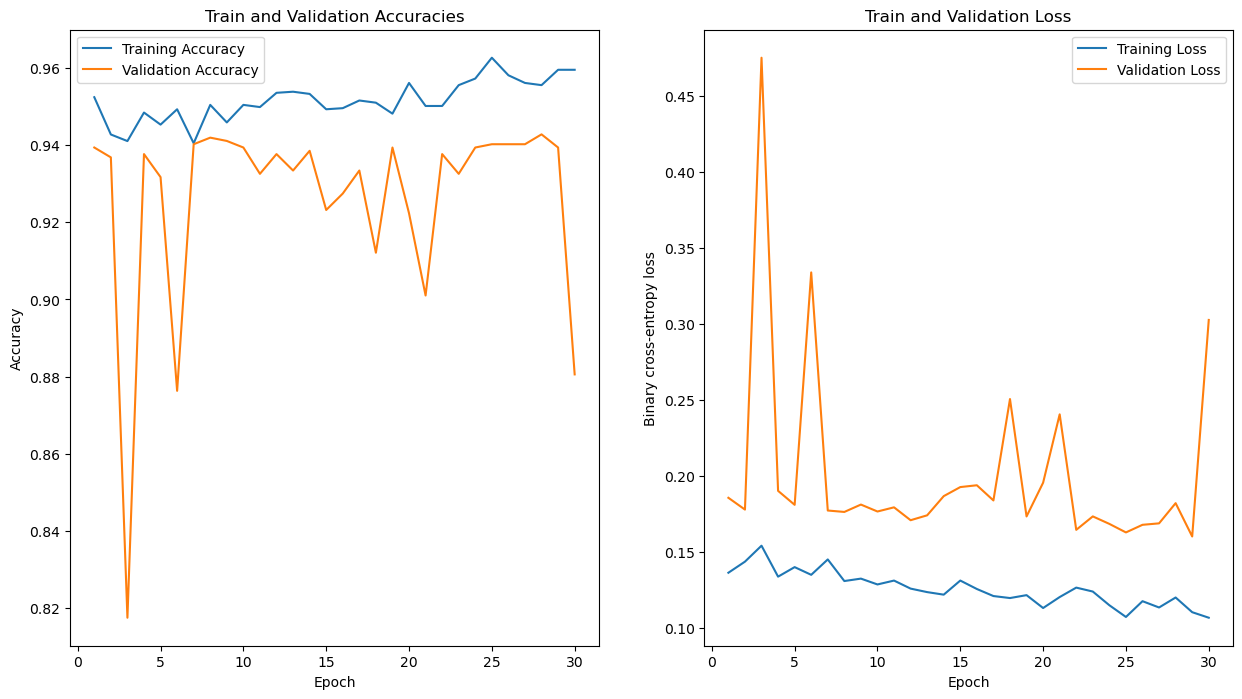

In [59]:
vis.plot_loss_accuracy(history2)
plt.show()

In [26]:
results_train = model2.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.1248 - accuracy: 0.9505


In [27]:
results_test = model2.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.9333


In [28]:
results_train

[0.12475898861885071, 0.9504837989807129]

In [29]:
results_test

[0.18135693669319153, 0.9333333373069763]

### Model 3: Neural Network with Dense and Drop Layers

In [30]:
np.random.seed(123)
model3 = models.Sequential()
model3.add(layers.Flatten(input_shape=(64, 64, 1)))
model3.add(layers.Dense(200, activation='relu'))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(50, activation='relu'))
model3.add(layers.Dense(25, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(7, activation='relu'))
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [60]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history3 = model3.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 1s 6ms/step - loss: 0.1678 - acc: 0.9360 - val_loss: 0.1830 - val_acc: 0.9352
Epoch 2/30
110/110 [==============================] - 1s 5ms/step - loss: 0.1680 - acc: 0.9371 - val_loss: 0.1869 - val_acc: 0.9258
Epoch 3/30
110/110 [==============================] - 1s 6ms/step - loss: 0.1580 - acc: 0.9400 - val_loss: 0.1849 - val_acc: 0.9292
Epoch 4/30
110/110 [==============================] - 1s 5ms/step - loss: 0.1635 - acc: 0.9370 - val_loss: 0.1906 - val_acc: 0.9224
Epoch 5/30
110/110 [==============================] - 1s 5ms/step - loss: 0.1528 - acc: 0.9411 - val_loss: 0.2466 - val_acc: 0.8985
Epoch 6/30
110/110 [==============================] - 1s 5ms/step - loss: 0.1589 - acc: 0.9326 - val_loss: 0.2488 - val_acc: 0.8942
Epoch 7/30
110/110 [==============================] - 0s 4ms/step - loss: 0.1666 - acc: 0.9350 - val_loss: 0.1789 - val_acc: 0.9369
Epoch 8/30
110/110 [==============================] - 0s 4ms/step - loss: 0.

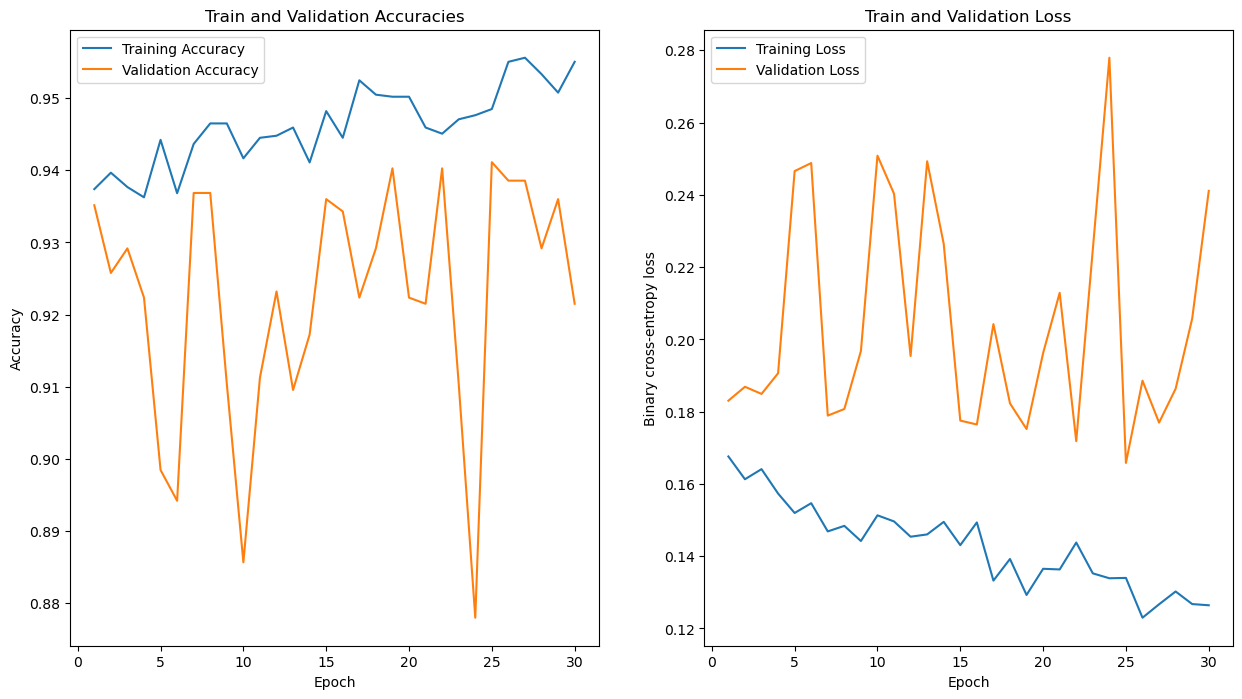

In [61]:
vis.plot_loss_accuracy(history3)

In [32]:
results_train = model3.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.1359 - accuracy: 0.9451


In [33]:
results_test = model3.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 2ms/step - loss: 0.1833 - accuracy: 0.9308


In [34]:
results_train

[0.13594718277454376, 0.9450768232345581]

In [35]:
results_test

[0.18333521485328674, 0.9307692050933838]

### Model 4: Convolutional Neural Network (CNN)

In [36]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [37]:
history4 = model4.fit(train_images,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 7s 64ms/step - loss: 0.6365 - acc: 0.6602 - val_loss: 0.5826 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 7s 61ms/step - loss: 0.6006 - acc: 0.7095 - val_loss: 0.5784 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.5626 - acc: 0.7430 - val_loss: 0.5644 - val_acc: 0.7295
Epoch 4/30
110/110 [==============================] - 7s 67ms/step - loss: 0.5660 - acc: 0.7258 - val_loss: 0.5444 - val_acc: 0.7295
Epoch 5/30
110/110 [==============================] - 7s 61ms/step - loss: 0.5285 - acc: 0.7355 - val_loss: 0.5235 - val_acc: 0.7295
Epoch 6/30
110/110 [==============================] - 7s 63ms/step - loss: 0.4827 - acc: 0.7657 - val_loss: 0.4281 - val_acc: 0.7483
Epoch 7/30
110/110 [==============================] - 7s 60ms/step - loss: 0.4331 - acc: 0.7892 - val_loss: 0.3596 - val_acc: 0.8174
Epoch 8/30
110/110 [==============================] - 7s 61ms/step - 

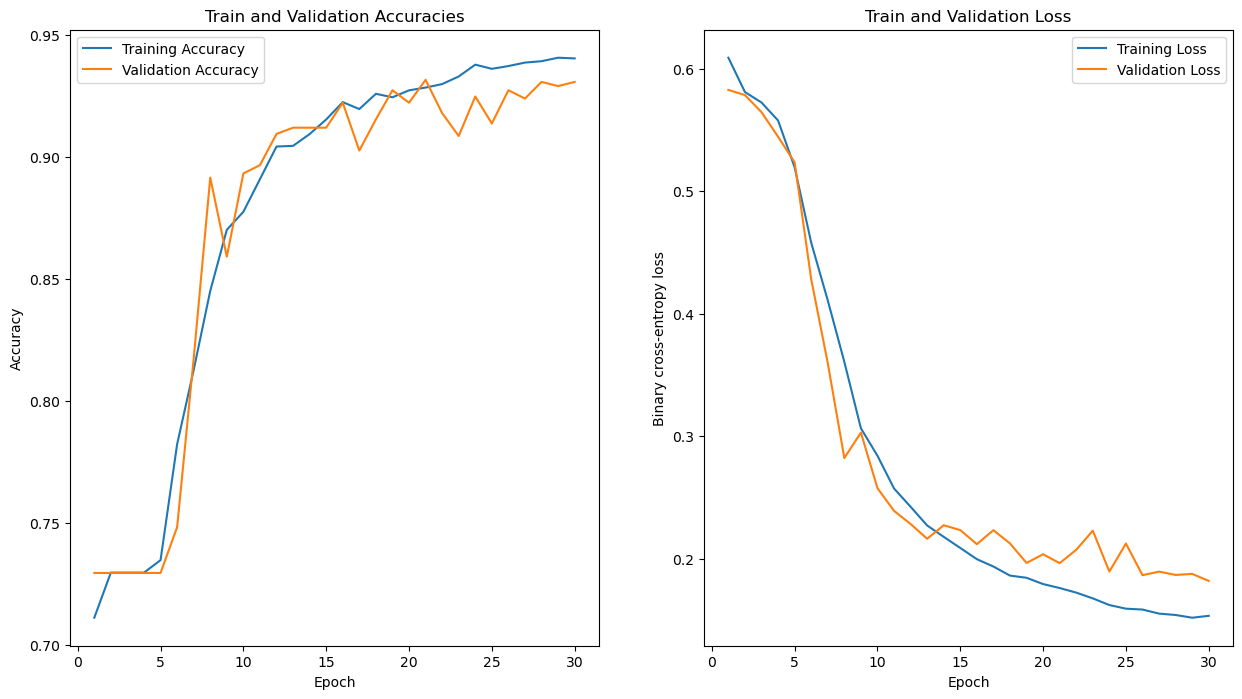

In [63]:
vis.plot_loss_accuracy(history4)
plt.show()

In [39]:
results_train = model4.evaluate(train_images, train_labels)

110/110 [==============================] - 2s 16ms/step - loss: 0.1411 - acc: 0.9471


In [40]:
results_test = model4.evaluate(test_images, test_labels)

37/37 [==============================] - 1s 15ms/step - loss: 0.1731 - acc: 0.9333


In [41]:
results_train

[0.14112241566181183, 0.9470688700675964]

In [42]:
results_test

[0.17309874296188354, 0.9333333373069763]

### Model 5: Base CNN with Focal Loss to solve class imbalancement 

In [43]:
#pip install focal-loss

In [44]:
from focal_loss import BinaryFocalLoss

In [45]:
model_fl = models.Sequential()
model_fl.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Flatten())
model_fl.add(layers.Dense(64, activation='relu'))
model_fl.add(layers.Dense(1, activation='sigmoid'))

model_fl.compile(
    loss=BinaryFocalLoss(gamma=2),
    optimizer= 'sgd',
    metrics=['acc']
)

In [46]:
train_images.shape

(3514, 64, 64, 1)

In [47]:
val_images.shape

(1172, 64, 64, 1)

In [48]:
val_labels.shape

(1172,)

In [49]:
history_base_fl = model_fl.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels)
)

Epoch 1/30
110/110 [==============================] - 8s 62ms/step - loss: 0.1543 - acc: 0.7414 - val_loss: 0.1487 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 7s 61ms/step - loss: 0.1490 - acc: 0.7249 - val_loss: 0.1461 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 7s 62ms/step - loss: 0.1439 - acc: 0.7377 - val_loss: 0.1432 - val_acc: 0.7295
Epoch 4/30
110/110 [==============================] - 7s 61ms/step - loss: 0.1439 - acc: 0.7206 - val_loss: 0.1396 - val_acc: 0.7295
Epoch 5/30
110/110 [==============================] - 7s 61ms/step - loss: 0.1371 - acc: 0.7359 - val_loss: 0.1354 - val_acc: 0.7295
Epoch 6/30
110/110 [==============================] - 7s 62ms/step - loss: 0.1351 - acc: 0.7153 - val_loss: 0.1261 - val_acc: 0.7312
Epoch 7/30
110/110 [==============================] - 7s 61ms/step - loss: 0.1249 - acc: 0.7367 - val_loss: 0.1217 - val_acc: 0.7321
Epoch 8/30
110/110 [==============================] - 7s 60ms/step - 

In [50]:
# test_x_fl, test_y_fl = next(test_generator)

# results_test = model_fl.evaluate(test_x_fl, test_y_fl)

In [51]:
model_fl.summary()  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

In [52]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(train_labels), class_weight.compute_class_weight('balanced',np.unique(train_labels), train_labels)))

/Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1. 1. 1. ... 0. 0. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [53]:
class_weight = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels,
)

array([1.84947368, 0.68525741])

### Model 6: Transfer Learning - ResNet50V2

In [54]:
from tensorflow.keras.applications import ResNet50V2

In [55]:
resnet50 = ResNet50V2(
    weights="imagenet",
    input_shape=(64, 64, 1),
    include_top=False
)

ValueError: The input must have 3 channels; got `input_shape=(64, 64, 1)`

In [ ]:
model2 = models.Sequential()

model2.add(resnet50)    
model2.add(layers.Flatten())
model2.add(layers.Dense(units = 128, activation = "relu"))
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(units = 1, activation = "sigmoid"))

In [ ]:
resnet50.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model2.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model2.trainable_weights))

In [ ]:
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
hist2 = model2.fit(
    train_images,
    validation_data=(val_images, val_labels),
    epochs=5
)

In [ ]:
test_results2 = model2.evaluate(test2)

In [ ]:
model2.summary()

### Model 7: CNN with Image Augumentation 

In [64]:
train_datagen_aug = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3,
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

In [66]:
train_aug = train_datagen_aug.flow_from_directory(TRAIN_PATH,
                                               batch_size=128,
                                               target_size=(64,64),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

test_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        TEST_PATH, 
        target_size=(64, 64), 
        batch_size = BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
val_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        VAL_PATH, 
        target_size=(64, 64),
        batch_size = BATCH_SIZE,
        class_mode='binary')

Found 3514 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [67]:
model_aug = models.Sequential()
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(64, activation='relu'))
model_aug.add(layers.Dense(1, activation='sigmoid'))

model_aug.compile(loss=BinaryFocalLoss(gamma=2),
              optimizer= 'sgd',
              metrics=['acc'])

In [68]:
history_aug = model_aug.fit(
    train_aug, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_aug
)

Epoch 1/30
28/28 [==============================] - 36s 1s/step - loss: 0.1578 - acc: 0.7085 - val_loss: 0.1466 - val_acc: 0.7295
Epoch 2/30
28/28 [==============================] - 35s 1s/step - loss: 0.1466 - acc: 0.7380 - val_loss: 0.1457 - val_acc: 0.7295
Epoch 3/30
28/28 [==============================] - 35s 1s/step - loss: 0.1480 - acc: 0.7275 - val_loss: 0.1451 - val_acc: 0.7295
Epoch 4/30
28/28 [==============================] - 36s 1s/step - loss: 0.1491 - acc: 0.7230 - val_loss: 0.1444 - val_acc: 0.7295
Epoch 5/30
28/28 [==============================] - 35s 1s/step - loss: 0.1462 - acc: 0.7316 - val_loss: 0.1436 - val_acc: 0.7295
Epoch 6/30
28/28 [==============================] - 35s 1s/step - loss: 0.1462 - acc: 0.7291 - val_loss: 0.1425 - val_acc: 0.7295
Epoch 7/30
28/28 [==============================] - 35s 1s/step - loss: 0.1469 - acc: 0.7214 - val_loss: 0.1417 - val_acc: 0.7295
Epoch 8/30
28/28 [==============================] - 36s 1s/step - loss: 0.1450 - acc: 0.72

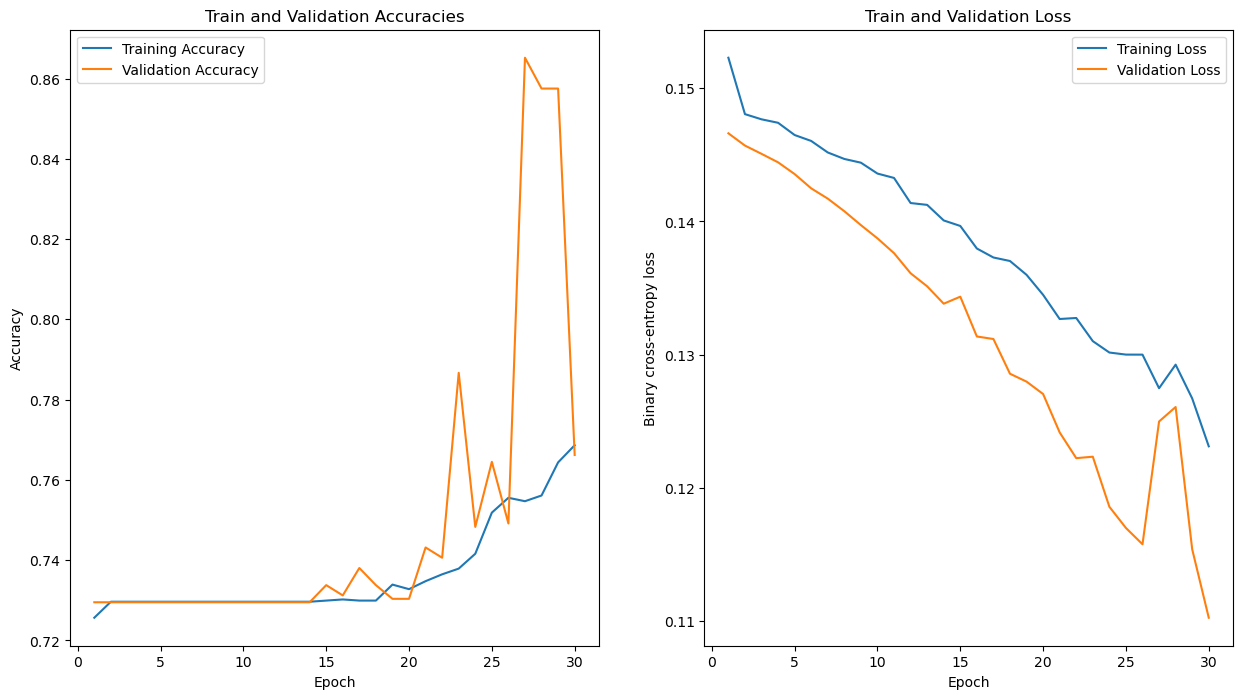

In [70]:
vis.plot_loss_accuracy(history_aug)

In [ ]:
test_results_aug = model_aug.evaluate(test_aug)

In [ ]:
model_aug.summary()

## Analysis, Conclusions, and Future Work